In [14]:
import numpy as np 
import pandas as pd 
import os 
import random 
from tqdm import tqdm 
import torch 
import torch.nn as nn 
import json 
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer, AlbertTokenizer, AutoModelForSequenceClassification
import pickle
import pandas_ta as ta # needed for processing chart data 
from random import randrange # needed for random agent
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor 
from sklearn.metrics import f1_score  
import ccxt 

# json -> csv 변환 

In [15]:
with open("BTC_USDT-4h_interval.json") as f: 
    d = json.load(f) 
    
chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp",
                                    1:"open",
                                    2:"high",
                                    3:"low", 
                                    4:"close",
                                    5:"volume"}) 

def process(df):
    binance = ccxt.binance() 
    dates = df['timestamp'].values 
    timestamp = [] 
    for i in range(len(dates)):
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df['datetime'] = timestamp 
    df = df.drop(columns={'timestamp'}) 
    return df

chart_df = process(chart_df) 

hours, days, months, years = [],[],[],[] 

for dt in tqdm(chart_df['datetime']):
    dtobj = pd.to_datetime(dt) 
    hour = dtobj.hour 
    day = dtobj.day 
    month = dtobj.month 
    year = dtobj.year 
    hours.append(hour)
    days.append(day) 
    months.append(month)
    years.append(year) 
    
chart_df['years'], chart_df['months'], chart_df['days'], chart_df['hours'] = years, months, days, hours
    
high_change, low_change = [], [] 
close = chart_df['close'].values 
high = chart_df['high'].values 
low = chart_df['low'].values 
for i in range(close.shape[0]-1):
    high_delta = (high[i+1] - close[i]) / close[i] 
    low_delta = (low[i+1] - close[i]) / close[i]
    high_change.append(high_delta) 
    low_change.append(low_delta)
high_change.append(None) 
low_change.append(None)

chart_df['high_delta'] = high_change
chart_df['low_delta'] = low_change 

chart_df.dropna(inplace=True) 

chart_df

100%|██████████| 10560/10560 [00:01<00:00, 7092.40it/s]


,open,high,low,close,volume,datetime,years,months,days,hours,high_delta,low_delta
0,4261.48,4349.99,4261.32,4349.99,82.088865,2017-08-17 04:00:00,2017,8,17,4,0.031127,-0.003832
1,4333.32,4485.39,4333.32,4427.30,63.619882,2017-08-17 08:00:00,2017,8,17,8,0.013121,-0.021205
2,4436.06,4485.39,4333.42,4352.34,174.562001,2017-08-17 12:00:00,2017,8,17,12,0.000574,-0.034832
3,4352.33,4354.84,4200.74,4325.23,225.109716,2017-08-17 16:00:00,2017,8,17,16,0.010279,-0.015414
4,4307.56,4369.69,4258.56,4285.08,249.769913,2017-08-17 20:00:00,2017,8,17,20,0.012961,-0.035115
...,...,...,...,...,...,...,...,...,...,...,...,...
10554,22485.27,22796.71,20846.00,22127.91,64139.981750,2022-06-14 00:00:00,2022,6,14,0,0.055811,-0.016459
10555,22127.92,23362.88,21763.71,22877.52,43892.535610,2022-06-14 04:00:00,2022,6,14,4,0.004478,-0.050368
10556,22877.52,22979.96,21725.22,21994.56,22494.024070,2022-06-14 08:00:00,2022,6,14,8,0.036620,-0.008345
10557,21994.56,22800.00,21811.01,22680.38,29165.257260,2022-06-14 12:00:00,2022,6,14,12,0.004263,-0.024426


# Feature Engineering

In [16]:
chart_df.set_index(pd.DatetimeIndex(chart_df['datetime']), inplace=True) 

chart_df['ebsw'] = chart_df.ta.ebsw(lookahead=False) 
chart_df['cmf'] = chart_df.ta.cmf(lookahead=False) 
chart_df['rsi/100'] = chart_df.ta.rsi(lookahead=False) / 100 
chart_df['vwap'] = chart_df.ta.vwap(lookahead=False) 
chart_df['high/low'] = chart_df['high'] / chart_df['low'] 
chart_df['close/open'] = chart_df['close'] / chart_df['open'] 
chart_df['high/open'] = chart_df['high'] / chart_df['open'] 
chart_df['low/open'] = chart_df['low'] / chart_df['open'] 

for i in tqdm(range(1, 4)): 
    for col in ['open', 'high', 'low', 'close', 'volume', 'vwap']:
        val = chart_df[col].values 
        val_ret = [None for _ in range(i)] 
        for j in range(i, len(val)): 
            if val[j-i] == 0:
                ret = 1 
            else:
                ret = val[j] / val[j-i] 
            val_ret.append(ret) 
        chart_df['{}_change_{}'.format(col, i)] = val_ret 
            
    

chart_df.dropna(inplace=True) 
chart_df.drop(columns={'datetime', 'open', 'high', 'low', 'close', 'volume', 'vwap'}, inplace=True) 

100%|██████████| 3/3 [00:00<00:00, 13.38it/s]


In [17]:
chart_df.head(2)

,years,months,days,hours,high_delta,low_delta,ebsw,cmf,rsi/100,high/low,...,low_change_2,close_change_2,volume_change_2,vwap_change_2,open_change_3,high_change_3,low_change_3,close_change_3,volume_change_3,vwap_change_3
datetime,,,,,,,,,,,,,,,,,,,,,
2017-08-23 16:00:00,2017,8,23,16,0.014957,-0.011481,0.00000,0.121501,0.514396,1.038033,...,1.011464,0.971468,1.293382,1.009008,1.034863,1.034916,1.016898,1.010354,1.231233,1.016728
2017-08-23 20:00:00,2017,8,23,20,0.022008,-0.007049,0.57735,0.097590,0.512374,1.026746,...,0.980521,0.980215,0.642973,0.999909,1.013438,0.984992,1.003155,0.970746,1.130291,1.008057


# Train High Model

In [18]:
# train/validation/test split 
train_size = int(chart_df.shape[0] * 0.8) 
train_df = chart_df.iloc[:train_size,:] 

val_size = int(chart_df.shape[0] * 0.1) 
val_df = chart_df.iloc[train_size:train_size+val_size,:]  

test_df = chart_df.iloc[train_size+val_size:, :] 

In [19]:
input_columns = [] 
for col in train_df.columns:
    if col != 'low_delta' and col != 'years': 
        input_columns.append(col) 
        
X_train = train_df[input_columns].values 
Y_train = train_df['high_delta'].values 
Y_train = Y_train.reshape((-1,1))

X_val = val_df[input_columns].values
Y_val = val_df['high_delta'].values 
Y_val = Y_val.reshape((-1,1))

X_test = test_df[input_columns].values 
Y_test = test_df['high_delta'].values  
Y_test = Y_test.reshape((-1,1))

In [20]:
reg_high = TabNetRegressor() 

reg_high.fit(X_train, Y_train, 
             eval_set=[(X_val, Y_val)], 
             max_epochs=100, 
             patience=100)  

Device used : cuda
epoch 0  | loss: 0.36774 | val_0_mse: 0.41214 |  0:00:00s
epoch 1  | loss: 0.04833 | val_0_mse: 0.00701 |  0:00:01s
epoch 2  | loss: 0.01159 | val_0_mse: 0.00293 |  0:00:02s
epoch 3  | loss: 0.00412 | val_0_mse: 0.00066 |  0:00:03s
epoch 4  | loss: 0.00202 | val_0_mse: 0.00028 |  0:00:03s
epoch 5  | loss: 0.00162 | val_0_mse: 0.00016 |  0:00:04s
epoch 6  | loss: 0.00139 | val_0_mse: 0.00012 |  0:00:05s
epoch 7  | loss: 0.00129 | val_0_mse: 0.00013 |  0:00:06s
epoch 8  | loss: 0.00123 | val_0_mse: 0.00013 |  0:00:06s
epoch 9  | loss: 0.0012  | val_0_mse: 0.00014 |  0:00:07s
epoch 10 | loss: 0.00117 | val_0_mse: 0.00013 |  0:00:08s
epoch 11 | loss: 0.00113 | val_0_mse: 0.00012 |  0:00:08s
epoch 12 | loss: 0.0011  | val_0_mse: 0.00012 |  0:00:09s
epoch 13 | loss: 0.00107 | val_0_mse: 0.00012 |  0:00:10s
epoch 14 | loss: 0.00104 | val_0_mse: 0.00013 |  0:00:10s
epoch 15 | loss: 0.001   | val_0_mse: 0.00012 |  0:00:11s
epoch 16 | loss: 0.00097 | val_0_mse: 0.00012 |  0:00

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Y_pred = reg_high.predict(X_test).flatten() 

print("MSE = {}".format(mean_squared_error(Y_test, Y_pred))) 
print("MAE = {}".format(mean_absolute_error(Y_test, Y_pred))) 

MSE = 0.0001048256689187855
MAE = 0.007808809547850269


<Figure size 432x288 with 0 Axes>

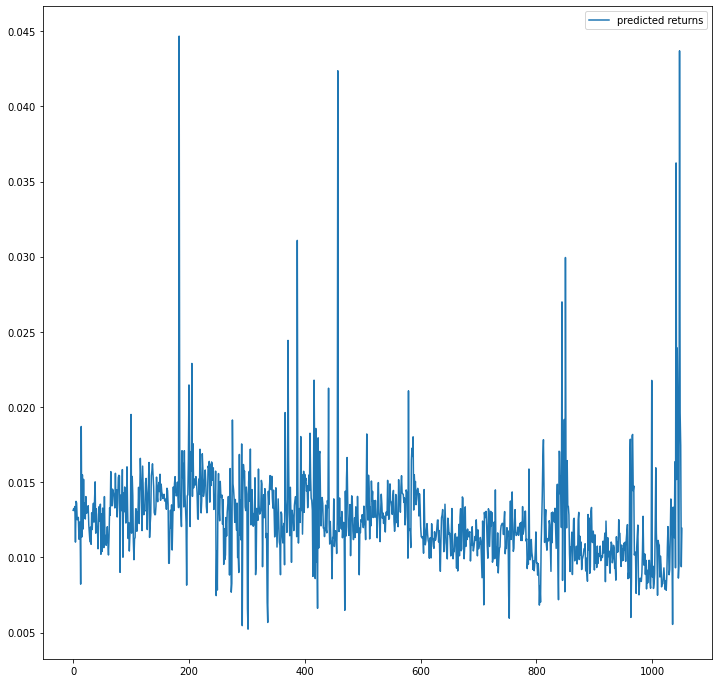

In [22]:
plt.figure()
plt.figure(figsize=(12, 12))
plt.plot(Y_pred, label="predicted returns") 
plt.legend()

<Figure size 432x288 with 0 Axes>

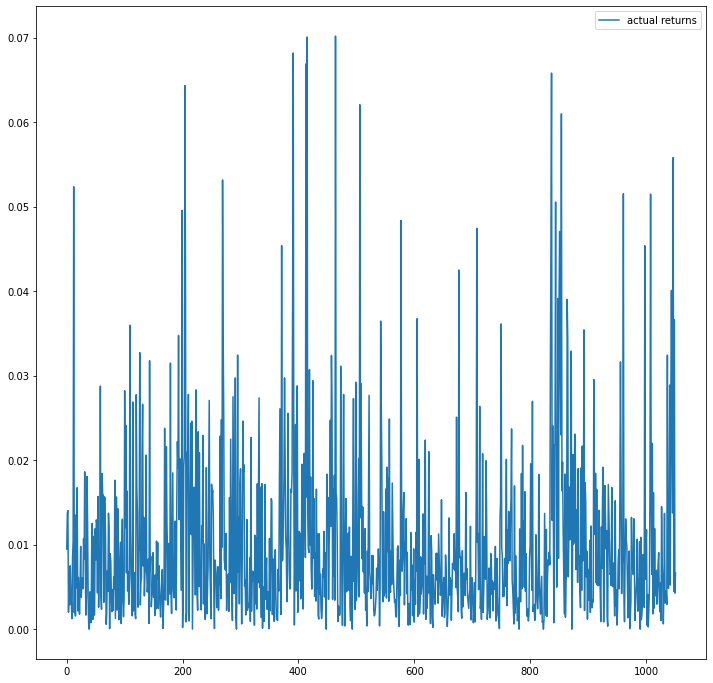

In [23]:
plt.figure()
plt.figure(figsize=(12, 12))
plt.plot(Y_test, label="actual returns") 
plt.legend()


# Train Low Model

In [24]:
input_columns = [] 
for col in train_df.columns:
    if col != 'high_delta' and col != 'years': 
        input_columns.append(col) 

X_train = train_df[input_columns].values 
Y_train = train_df['low_delta'].values 
Y_train = Y_train.reshape((-1,1))

X_val = val_df[input_columns].values
Y_val = val_df['low_delta'].values 
Y_val = Y_val.reshape((-1,1))

X_test = test_df[input_columns].values 
Y_test = test_df['low_delta'].values  
Y_test = Y_test.reshape((-1,1))

In [25]:
reg_low = TabNetRegressor() 

reg_low.fit(X_train, Y_train, 
            eval_set=[(X_val, Y_val)], 
            max_epochs=100, 
            patience=100)  

Device used : cuda
epoch 0  | loss: 0.37936 | val_0_mse: 0.49783 |  0:00:00s
epoch 1  | loss: 0.05511 | val_0_mse: 0.01912 |  0:00:01s
epoch 2  | loss: 0.01569 | val_0_mse: 0.00103 |  0:00:01s
epoch 3  | loss: 0.00698 | val_0_mse: 0.00051 |  0:00:02s
epoch 4  | loss: 0.00318 | val_0_mse: 0.00033 |  0:00:03s
epoch 5  | loss: 0.00207 | val_0_mse: 0.00027 |  0:00:04s
epoch 6  | loss: 0.00168 | val_0_mse: 0.00025 |  0:00:04s
epoch 7  | loss: 0.0015  | val_0_mse: 0.00026 |  0:00:05s
epoch 8  | loss: 0.00135 | val_0_mse: 0.00026 |  0:00:05s
epoch 9  | loss: 0.00127 | val_0_mse: 0.00025 |  0:00:06s
epoch 10 | loss: 0.00122 | val_0_mse: 0.00025 |  0:00:07s
epoch 11 | loss: 0.00119 | val_0_mse: 0.00024 |  0:00:07s
epoch 12 | loss: 0.00116 | val_0_mse: 0.00025 |  0:00:08s
epoch 13 | loss: 0.00113 | val_0_mse: 0.00025 |  0:00:09s
epoch 14 | loss: 0.00109 | val_0_mse: 0.00024 |  0:00:09s
epoch 15 | loss: 0.00106 | val_0_mse: 0.00024 |  0:00:10s
epoch 16 | loss: 0.00104 | val_0_mse: 0.00024 |  0:00

In [26]:
Y_pred = reg_low.predict(X_test).flatten() 

print("MSE = {}".format(mean_squared_error(Y_test, Y_pred))) 
print("MAE = {}".format(mean_absolute_error(Y_test, Y_pred)))  

MSE = 4.307122152635479e-05
MAE = 0.004433137810416228


<Figure size 432x288 with 0 Axes>

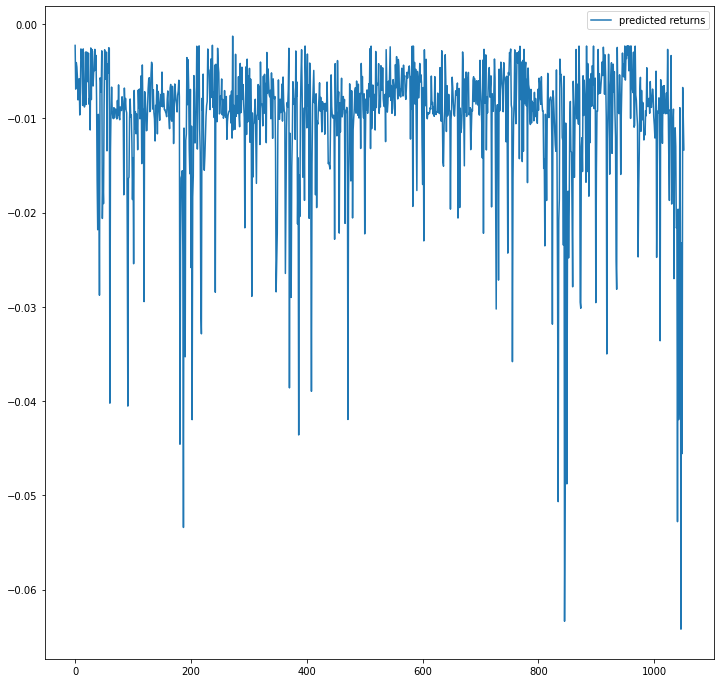

In [27]:
plt.figure()
plt.figure(figsize=(12, 12))
plt.plot(Y_pred, label="predicted returns") 
plt.legend() 

<Figure size 432x288 with 0 Axes>

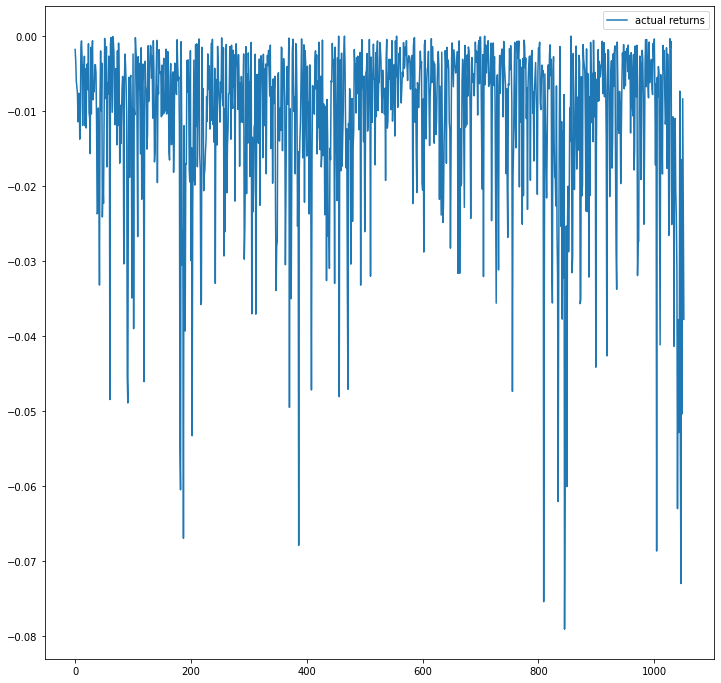

In [28]:
plt.figure()
plt.figure(figsize=(12, 12))
plt.plot(Y_test, label="actual returns") 
plt.legend()